In [4]:
def idplot(base, hops, _type, method, host=None):
    G = nx.Graph()
    g = {}
    for file in os.listdir(base):
        filename = os.fsdecode(file)
        if _type in filename and method in filename:
            with open(base + filename, "r") as csvfile:
                d = list(csv.reader(csvfile))
                for r in range(len(d) - (30 - hops)):
                    ip1 = d[r][2]
                    ip2 = d[r + 1][2]
                    effe = ["*", "ip"]
                    if ip1 not in effe and ip2 not in effe:
                        if ip1 not in g:
                            g[ip1] = []
                        if ip2 not in g[ip1]:
                            g[ip1].append(ip2)

    for k, v in g.items():
        G.add_node(k)
        for i in v:
            G.add_edge(k, i)

    return G


def draw(G):
    # _,degree = map(list, zip(*G.degree()))
    nx.draw_kamada_kawai(
        G,
        node_color=range(len(G.degree())),
        cmap=plt.cm.GnBu,
        # node_size=[(v * 500) + 1 for v in  degree],
        # with_labels=True,
    )

In [5]:
def cloud_draw(provider, hops, method):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 2, 1)  # Define 3 rows, 2 column, Activate subplot 1.
    base = f"../idp-castellotti-data/new-traceroutes/{provider}/"
    plt.subplot(321).set_title(f"{provider} starlink {hops} hops {method}")
    G = idplot(base=base, hops=8, _type="starlink", method=method)
    draw(G)
    plt.subplot(322).set_title(f"{provider} normal {hops} hops {method} ")
    G = idplot(base=base, hops=hops, _type="normal", method=method)
    draw(G)
    plt.show()

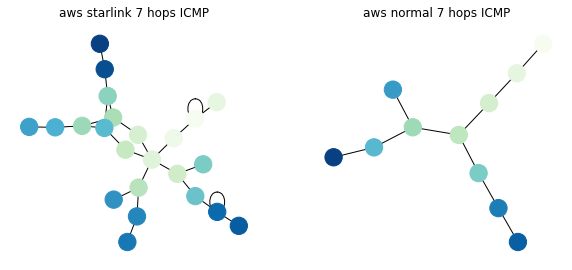

In [6]:
cloud_draw(provider="aws", hops=7, method="ICMP")

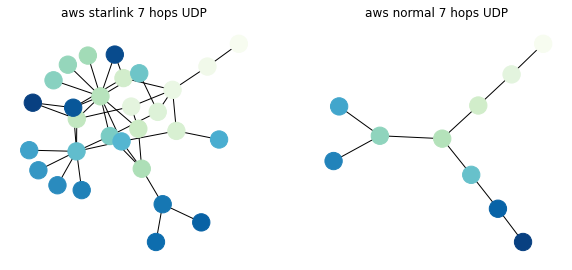

In [7]:
cloud_draw(provider="aws", hops=7, method="UDP")

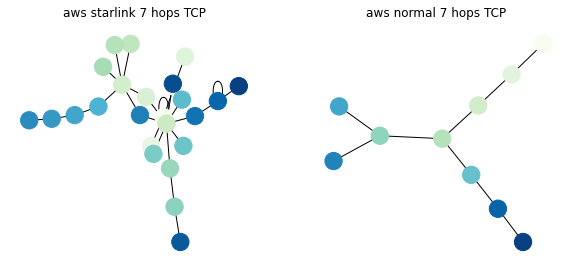

In [8]:
cloud_draw(provider="aws", hops=7, method="TCP")

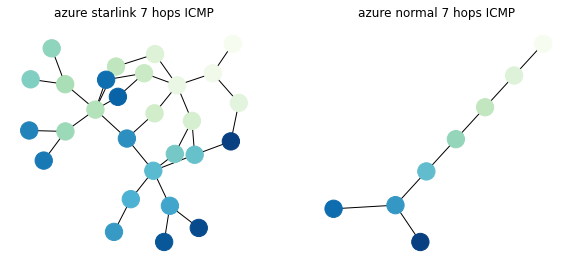

In [9]:
cloud_draw(provider="azure", hops=7, method="ICMP")

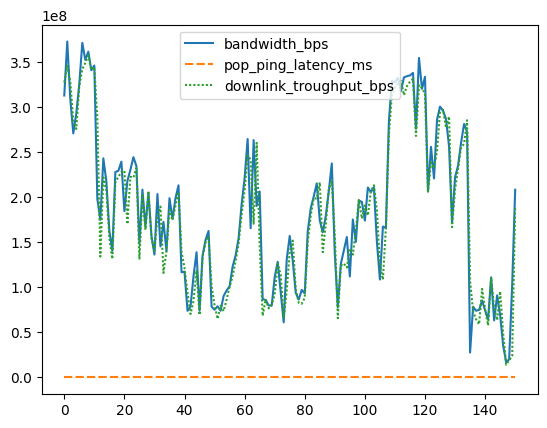

In [12]:

df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
plt.figure()


sns.lineplot(data=df[0:151], dashes=True)
for i in range(0, 151, 15):
    ax.axvline(i, color="red", linestyle="--")

plt.show()


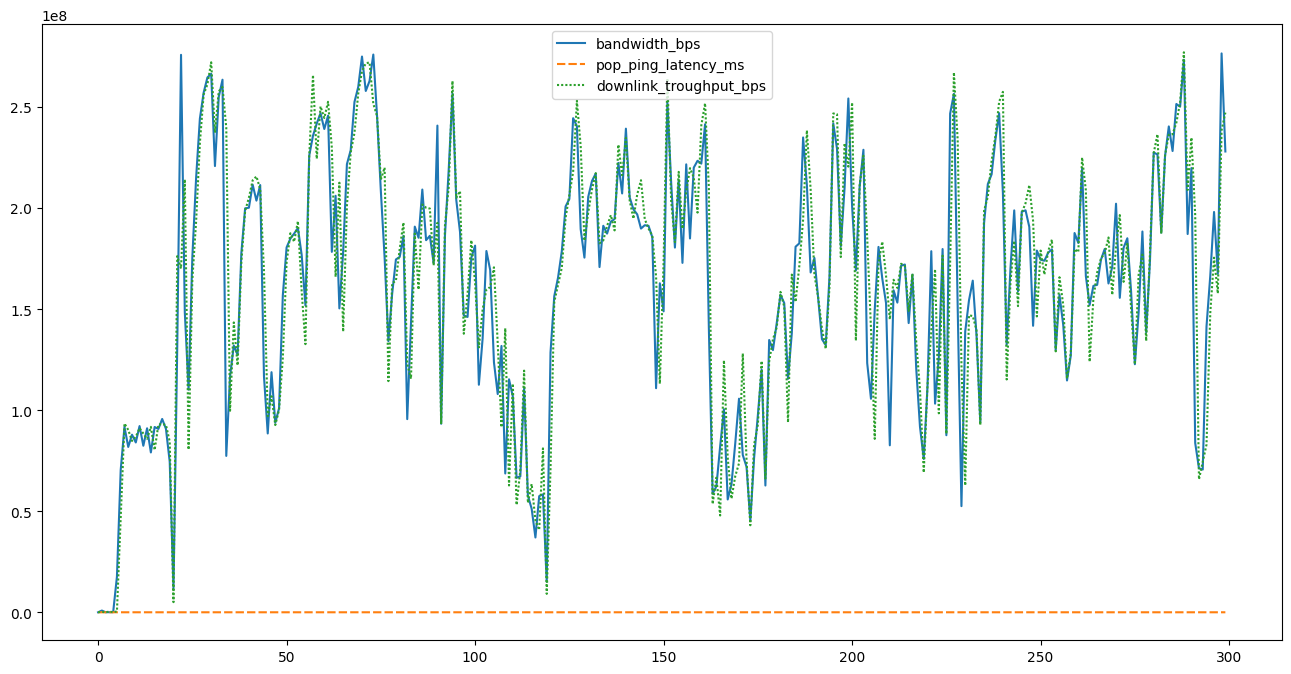

In [9]:
df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel_obstruction_map.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', origin='unix')
plt.figure(figsize=(16,8))
sns.lineplot(data=df[0:300], dashes=True)
# for i in range(0, 151, 15):
#     plt.axvline(i, color="red", linestyle="--")
plt.show()

<Figure size 640x480 with 0 Axes>

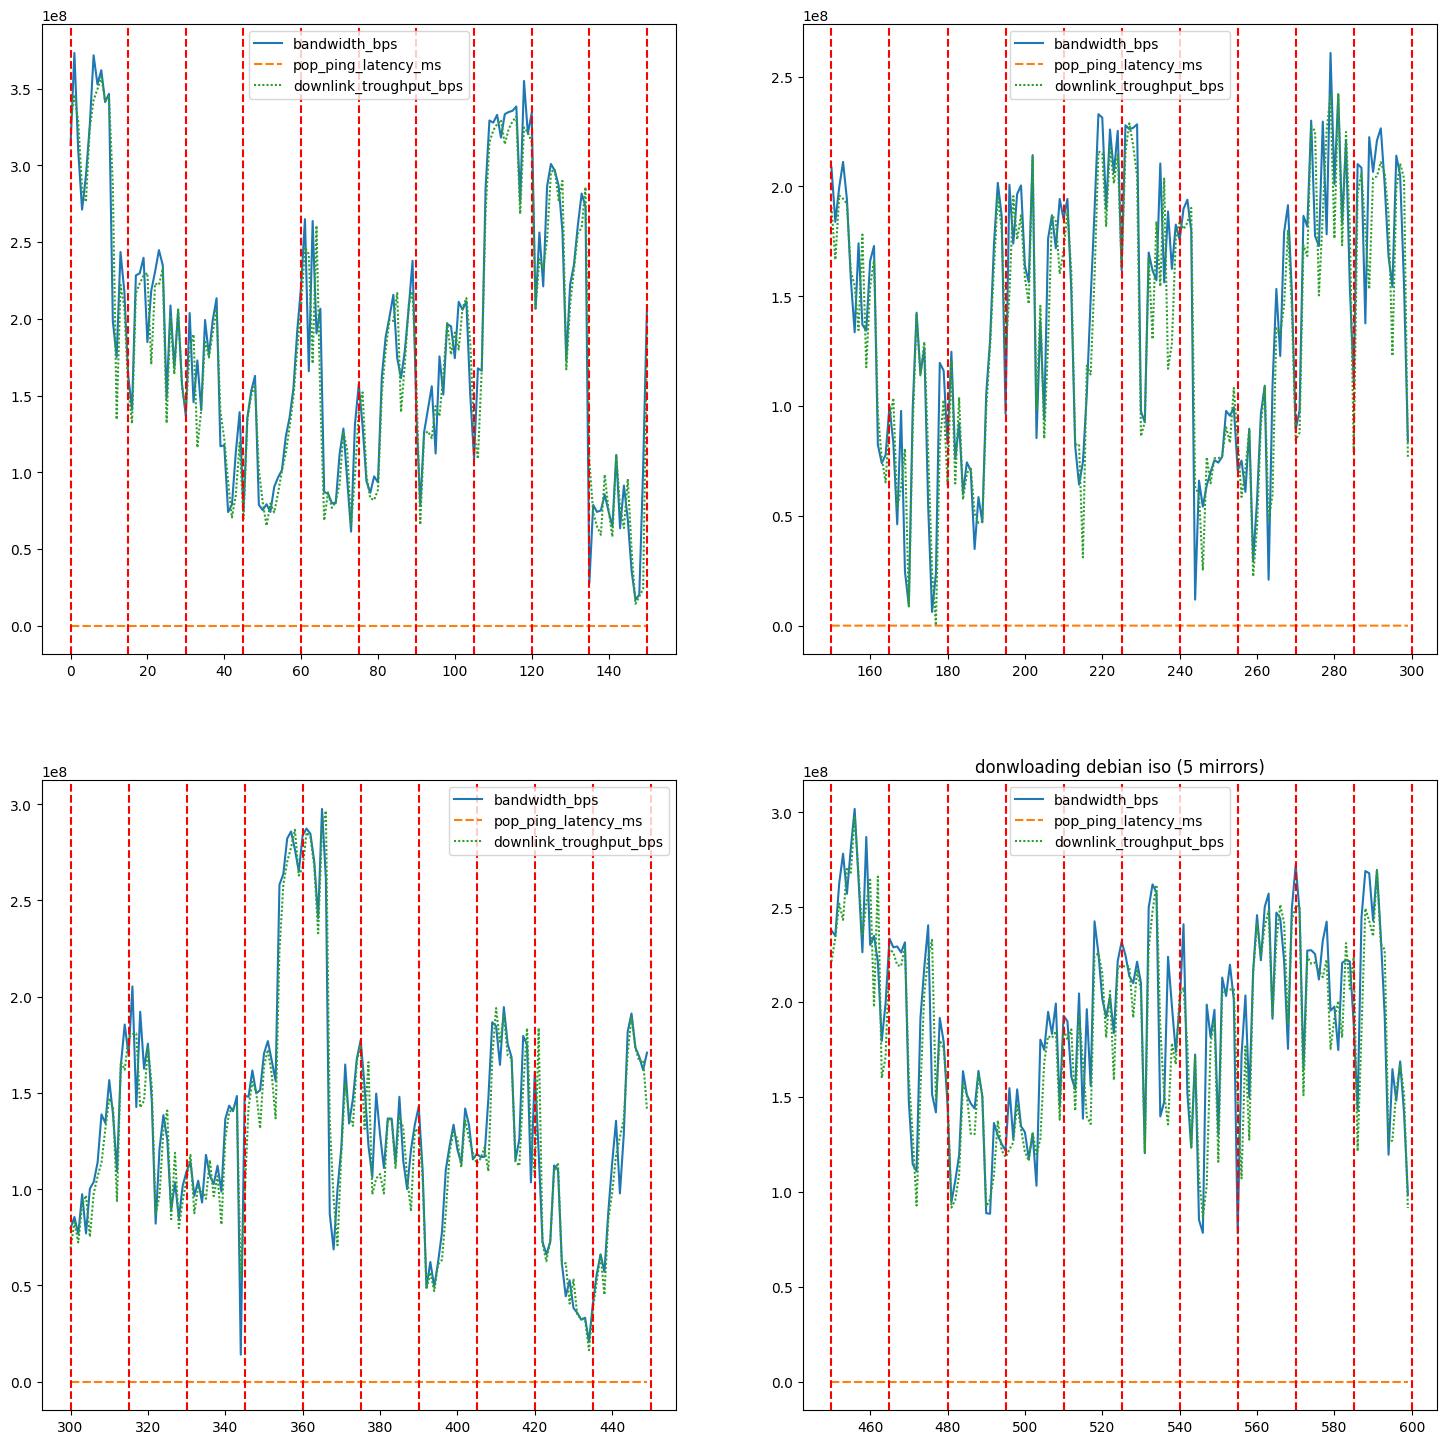

In [16]:
df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
plt.figure()

fig, axes = plt.subplots(2, 2, figsize=(18, 18))
plt.title("donwloading debian iso (5 mirrors)")

ax = sns.lineplot(data=df[0:151], dashes=True, ax=axes[0, 0])
for i in range(0, 151, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[150:300], dashes=True, ax=axes[0, 1])
for i in range(150, 301, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[300:450], dashes=True, ax=axes[1, 0])
for i in range(300, 451, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[450:600], dashes=True, ax=axes[1, 1])
for i in range(450, 601, 15):
    ax.axvline(i, color="red", linestyle="--")

plt.show()

In [15]:
# df = pd.read_csv("../idp-castellotti-data/visible_satellites_variable_distance.csv")
# plt.figure(figsize=(15, 8))
# sns.countplot(x=df["distance"]).set_title("number of satellites")
# plt.ylabel("# of satellites")
# plt.xlabel("distance (km)")
# plt.show()

In [16]:
# df0 = pd.read_csv("/home/rc/idp-castellotti-data/hist2.csv")
# df1 = pd.read_csv("/home/rc/idp-castellotti-data/hist3.csv")
# df2 = pd.read_csv("/home/rc/idp-castellotti-data/history.csv")
# df = pd.concat([df0, df1, df2], axis=1).reindex(df1.index)
# df.head()
# df.to_csv("/home/rc/idp-castellotti-data/hist.csv")

In [4]:
import json
import numpy as np
from common import detect_handovers
plt.rcParams.update({'figure.max_open_warning': 0})
list=detect_handovers("../idp-castellotti-data/raw_maps/")
for i,j in list:
    fig, ax = plt.subplots(1, 2,figsize=(12,7))
    map1 = json.load(open(i))
    map1 = map1["dishGetObstructionMap"]["snr"]
    map1 = np.array(map1).reshape(123, 123)
    map2 = json.load(open(j))
    map2 = map2["dishGetObstructionMap"]["snr"]
    map2 = np.array(map2).reshape(123, 123)
    ax[0].imshow(map1)
    ax[1].imshow(map2)
    plt.plot()

TypeError: detect_handovers() missing 2 required positional arguments: 'f2' and 'lista'

<Axes: >

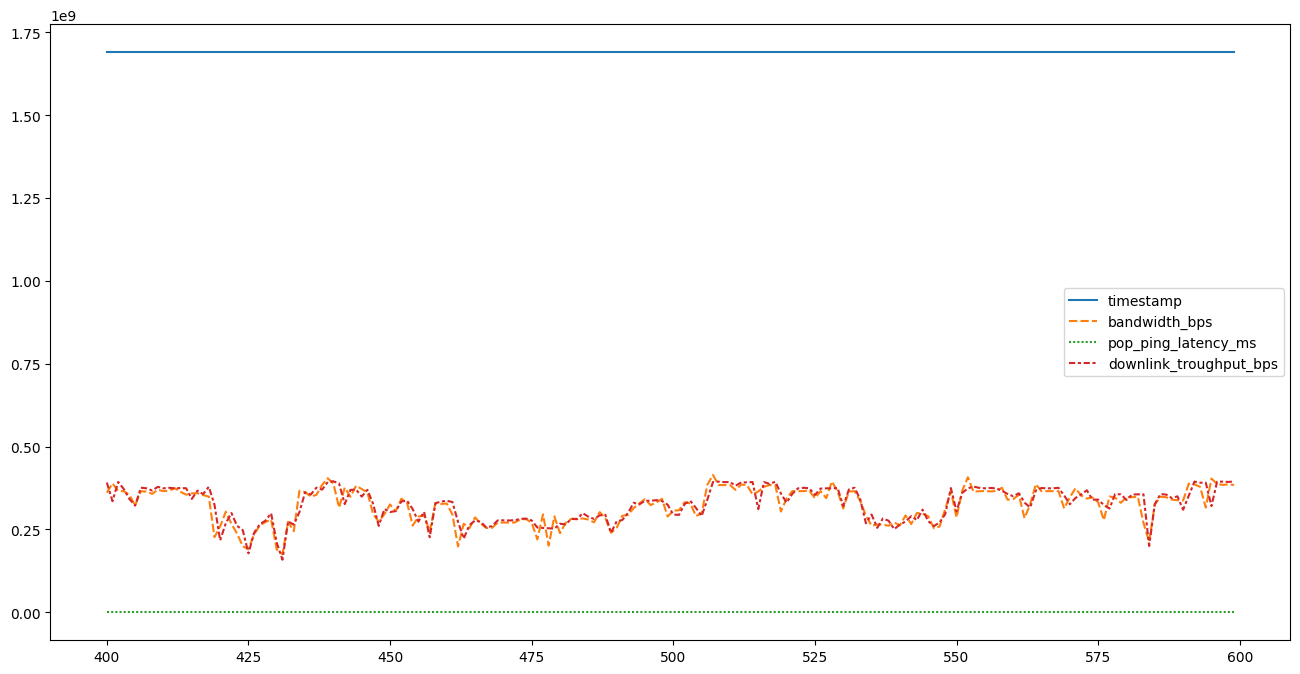

In [2]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# df = pd.read_csv("../idp-castellotti-data/large_file_download_5parallel_obstruction_map.csv")
# # df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', origin='unix')
# # print(df[400:401]["timestamp"])
# plt.figure(figsize=(16,8))
# sns.lineplot(data=df[400:600], dashes=True)
# # for i in range(0, 151, 15):
# #     plt.axvline(i, color="red", linestyle="--")
# # plt.show()

In [ ]:
# from here on we have the stuff I am gonna publish, so let's be tidy

In [1]:
from skyfield.api import load, wgs84

stations_url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
satellites = load.tle_file(stations_url)
print("Loaded", len(satellites), "satellites")
by_name = {sat.name: sat for sat in satellites}
satellite = by_name["STARLINK-1007"]

# year, month, day, hour, minute, second
ts = load.timescale()
t = ts.now()
a = satellite.at(t)
lat, lon = wgs84.latlon_of(a)
print("Latitude:", lat)
print("Longitude:", lon)

[#################################] 100% gp.php


Loaded 4626 satellites
Latitude: 23deg 23' 00.7"
Longitude: -108deg 35' 32.0"
